# Optimising machine learning models with Optuna

This Jupyter notebook goes through the basic usage of Optuna (optuna.org). Optuna is a machine learning model optimizer that may be used on any machine learning model type. Optuna uses heuristic (searching) algorithms to find the best model hyperparameters. It also allows more traditional alternatives to heuristic algorithms, such as grid dearch and random serach.

To install optuna (if not installed as part of the Titanic environment': `pip install optuna`. The visualisations require plotly (`pip install plotly`).

In [1]:
import optuna
import pandas as pd

import sklearn.ensemble
import sklearn.model_selection
from sklearn.linear_model import LogisticRegression

# The following are needed only to show Optuna images in a Jupyter Book
from IPython.display import Image, display

# Turn off optuna progress reporting
optuna.logging.set_verbosity(optuna.logging.WARNING)

# To save images you will also need to `pip install kaleido`

In [2]:
# Make images folder if it does not already exist
import os
if not os.path.exists('images'):
    os.makedirs('images')

## Optimize a simple problem

Find *x* that minmises *(x-2)^2*

(*x*=2 minimises output)

In [3]:
def objective(trial):
    
    # Set study parameter to vary
    x = trial.suggest_float('x', -10, 10)
    
    # Return value for optimisation
    return (x - 2) ** 2

study = optuna.create_study()
study.optimize(objective, n_trials=100)

# Run optimisation (default is to minimise objective)
study.best_params  

{'x': 1.9990161436479945}

## Download Titanic data

In [4]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

In [5]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)

# Drop Passengerid (axis=1 indicates we are removing a column rather than a row)
data.drop('PassengerId', inplace=True, axis=1)

## Divide into X (features) and y (labels)

In [6]:
# Split data into two DataFrames
X_df = data.drop('Survived',axis=1)
y_df = data['Survived']

# Convert DataFrames to NumPy arrays
X = X_df.values
y = y_df.values

## Optimize Hyperparameters

### Define a simple scikit-learn model

We start with a simple random forest model to classify Titanic survivors vs. non-survivors. We define a function called `objective` that encapsulates the whole training process and outputs the accuracy of the model.

In [7]:
def objective():

    # Define model
    model = sklearn.ensemble.RandomForestClassifier(    
        n_estimators=5, max_depth=3)
    
    # Assess accuracy with sklearn.model_selection.cross_val_score
    accuracy = sklearn.model_selection.cross_val_score(
        model, X, y, n_jobs=-1, cv=3).mean()
    
    return accuracy 

print(f'Accuracy: {objective():0.3f}')

Accuracy: 0.738


### Optimize hyperparameters of the model

The hyperparameters of the above algorithm are `n_estimators` and `max_depth` for which we can try different values to see if the model accuracy can be improved.

In [8]:
def objective(trial):
    
    # Set Optuna trial parameters and ranges
    n_estimators = trial.suggest_int('n_estimators', 2, 20)
    max_depth = int(trial.suggest_float('max_depth', 1, 32, log=True))
    
    # Set up model
    model = sklearn.ensemble.RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth)
    
    # Assess accuracy with sklearn.model_selection.cross_val_score
    accuracy = sklearn.model_selection.cross_val_score(
        model, X, y, n_jobs=-1, cv=3).mean()
    
    return accuracy

# Set up Optuna study - we need to specifiy that we wish to maximise objective
study = optuna.create_study(direction='maximize')

# Run optimisation
study.optimize(objective, n_trials=100)

# Get best model run
trial = study.best_trial

print(f'Accuracy: {trial.value:0.3f}')
print(f'Best hyperparameters: {trial.params}')

Accuracy: 0.823
Best hyperparameters: {'n_estimators': 15, 'max_depth': 8.587639351884242}


Note that `max_depth` is a float. This is because we asked for it to be varied over a log scale, and that requires a float. The actual `max_depth` used is the corresponding integer of that flaot.

### Building in conditional `if` statements

It is possible to condition hyperparameters using Python `if` statements. We can for instance include another classifier, a logistic regression classifier, in our hyperparameter optimsation and define hyperparameters specific to the random forest model and the logistic regression models.

In [9]:
def objective(trial):
    
    # All Optuna to choose classifier (Random Forest or logistic regression)
    classifier = trial.suggest_categorical(
        'classifier', ['RandomForest', 'LogisticRegression'])
    
    # If Random Forest set Optuna trial parameters for random forest
    if classifier == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 2, 20)
        max_depth = int(trial.suggest_float('max_depth', 1, 32, log=True))

        # Set up model
        model = sklearn.ensemble.RandomForestClassifier(
            n_estimators=n_estimators, max_depth=max_depth)
    
    # Otherwise set Optuna trial parameters for logistic regression
    else:
        c = trial.suggest_float('lr_c', 1e-10, 1e10, log=True)
        
        # Set up model
        model = LogisticRegression(C=c)
        
    # Run selected model        
    accuracy = sklearn.model_selection.cross_val_score(
        model, X, y, n_jobs=-1, cv=3).mean()

    return accuracy

# Set up Optuna study
study = optuna.create_study(direction='maximize')

# Run optimisation
study.optimize(objective, n_trials=100)

# Get best model run
trial = study.best_trial

print(f'Accuracy: {trial.value:0.3f}')
print(f'Best hyperparameters: {trial.params}')

Accuracy: 0.822
Best hyperparameters: {'classifier': 'RandomForest', 'n_estimators': 9, 'max_depth': 8.124323445767212}


### Plotting the study

Plotting the optimization history of the study.

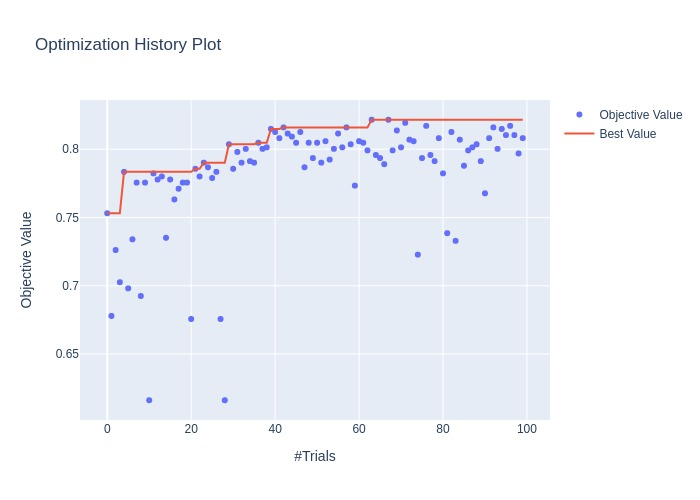

In [10]:
fig = optuna.visualization.plot_optimization_history(study)

# To display fig in an ordinary notebook use `fig.show()`
# The following is needed only to display the image in an online Jupyter Book
# Or is you wish to save the figure

filename = './images/temp.jpg'
fig.write_image(filename)
display(Image(filename))

Plotting the accuracies for each hyperparameter for each trial.

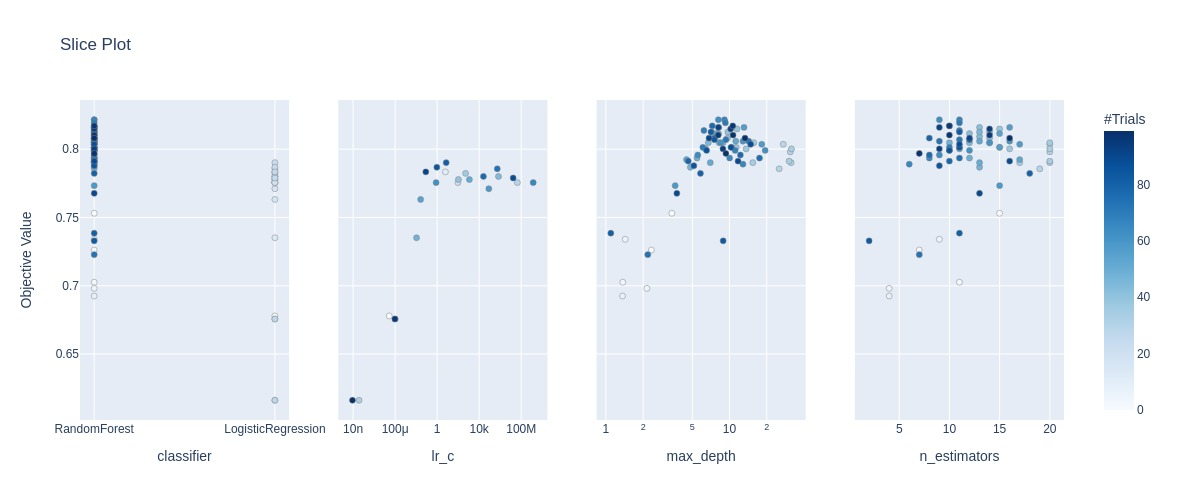

In [11]:
fig = optuna.visualization.plot_slice(study)

# To display fig in an orinary norebook use `fig.show()`
# The following is needed only to display the image in an online Jupyter Book
# Or is you wish to save the figure

filename = './images/temp.jpg'
fig.write_image(filename)
display(Image(filename))

Plotting the accuracy surface for the hyperparameters involved in the random forest model.

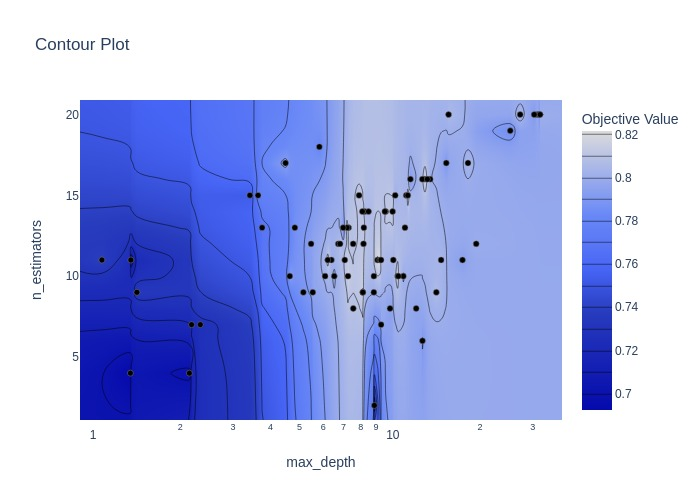

In [12]:
fig = optuna.visualization.plot_contour(study, params=['n_estimators', 'max_depth'])

# To display fig in an orinary norebook use `fig.show()`
# The following is needed only to display the image in an online Jupyter Book
# Or is you wish to save the figure

filename = './images/temp.jpg'
fig.write_image(filename)
display(Image(filename))

## Switching sampling Algorithms

Samplers continually narrow down the search space using the records of suggested parameter values and evaluated objective values,
leading to an optimal search space which giving off parameters leading to better objective values.
More detailed explanation of how samplers suggest parameters is in :class:`optuna.samplers.BaseSampler`.

Optuna provides the following sampling algorithms:

- Tree-structured Parzen Estimator algorithm implemented in :class:`optuna.samplers.TPESampler`

- CMA-ES (Covariance matrix adaptation evolution strategy) based algorithm implemented in :class:`optuna.samplers.CmaEsSampler`

- Grid Search implemented in :class:`optuna.samplers.GridSampler`

- Random Search implemented in :class:`optuna.samplers.RandomSampler`

The default sampler is :class:`optuna.samplers.TPESampler`.

We can define an alternative sampler when we define the study. Here we use a CMA-ES sampler.

In [13]:
def objective(trial):

    # Set Optuna trial parameters and ranges
    n_estimators = trial.suggest_int('n_estimators', 2, 20)
    max_depth = int(trial.suggest_float('max_depth', 1, 32, log=True))
    
    # Set up model
    clf = sklearn.ensemble.RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth)
    
    # Assess accuracy with sklearn.model_selection.cross_val_score
    accuracy = sklearn.model_selection.cross_val_score(
        clf, X, y, n_jobs=-1, cv=3).mean()
    
    return accuracy

# Set up Optuna study

study = optuna.create_study(direction='maximize', 
                            sampler=optuna.samplers.CmaEsSampler())

# Run optimisation
study.optimize(objective, n_trials=100)

# Get best model run
trial = study.best_trial

print(f'Accuracy: {trial.value:0.3f}')
print(f'Best hyperparameters: {trial.params}')

Accuracy: 0.827
Best hyperparameters: {'n_estimators': 10, 'max_depth': 7.610730760452772}


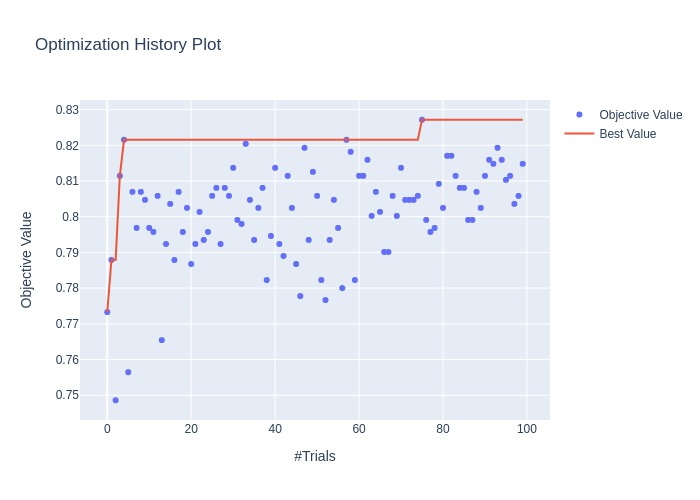

In [14]:
fig = optuna.visualization.plot_optimization_history(study)

# To display fig in an orinary norebook use `fig.show()`
# The following is needed only to display the image in an online Jupyter Book
# Or is you wish to save the figure

filename = './images/temp.jpg'
fig.write_image(filename)
display(Image(filename))

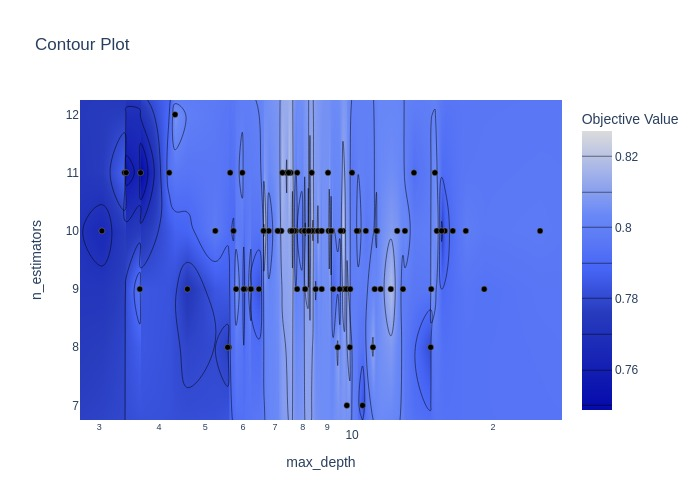

In [15]:
fig = optuna.visualization.plot_contour(study, params=['n_estimators', 'max_depth'])

# To display fig in an orinary norebook use `fig.show()`
# The following is needed only to display the image in an online Jupyter Book
# Or is you wish to save the figure

filename = './images/temp.jpg'
fig.write_image(filename)
display(Image(filename))

## Grid search

With grid search, the defined search space over-rides the trial suggestions in the objective. Grid seach can be effective when there are not too many hyperparamters and options to chose from. A broad grid search may be followed by a narrower one.

In [16]:
def objective(trial):

    # Set Optuna trial parameters and ranges
    n_estimators = trial.suggest_int('n_estimators', 2, 20)
    max_depth = int(trial.suggest_float('max_depth', 1, 32, log=True))
    
    # Set up model
    model = sklearn.ensemble.RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth)
    
    # Assess accuracy with sklearn.model_selection.cross_val_score
    accuracy = sklearn.model_selection.cross_val_score(
        model, X, y, n_jobs=-1, cv=3).mean()
    
    return accuracy

# Define search space: this will over-ride the suggestions in the objective 
#  function, but must be within the limits set by the suggestions
search_space = {
    "n_estimators": [2, 5, 10, 15, 20], 
    "max_depth": [1, 2, 5, 10, 20, 32]}

# Set up Optuna study
study = optuna.create_study(direction='maximize', 
                            sampler=optuna.samplers.GridSampler(search_space))

# Run optimisation
study.optimize(objective, n_trials=100)

# Get best model run
trial = study.best_trial

print(f'Accuracy: {trial.value:0.3f}')
print(f'Best hyperparameters: {trial.params}')

Accuracy: 0.817
Best hyperparameters: {'n_estimators': 20, 'max_depth': 10}


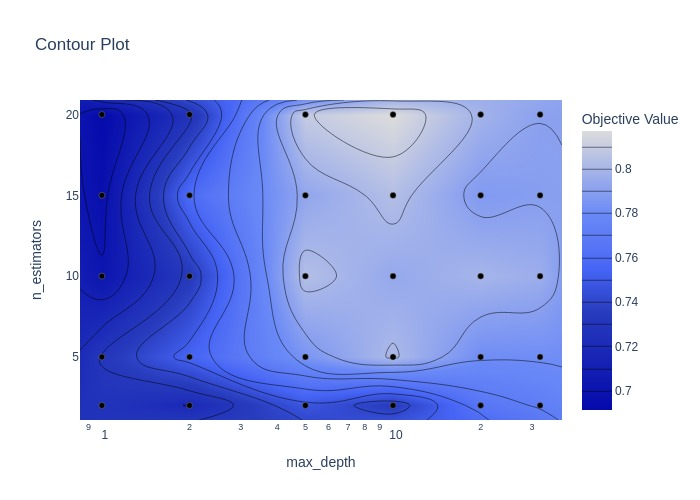

In [17]:
fig = optuna.visualization.plot_contour(study, params=['n_estimators', 'max_depth'])

# To display fig in an orinary norebook use `fig.show()`
# The following is needed only to display the image in an online Jupyter Book
# Or is you wish to save the figure

filename = './images/temp.jpg'
fig.write_image(filename)
display(Image(filename))

## Random search

Random search may be a ueful starting point for exploring hyperparamter optimisation. It may be followed by a grid search or one of the heuristic methods.

In [18]:
def objective(trial):

    # Set Optuna trial parameters and ranges
    n_estimators = trial.suggest_int('n_estimators', 2, 20)
    max_depth = int(trial.suggest_float('max_depth', 1, 32, log=True))
    
    # Set up model
    model = sklearn.ensemble.RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth)
    
    # Assess accuracy with sklearn.model_selection.cross_val_score
    accuracy = sklearn.model_selection.cross_val_score(
        model, X, y, n_jobs=-1, cv=3).mean()
    
    return accuracy

# Set up Optuna study
study = optuna.create_study(direction='maximize', 
                            sampler=optuna.samplers.RandomSampler())

# Run optimisation
study.optimize(objective, n_trials=100)

# Get best model run
trial = study.best_trial

print(f'Accuracy: {trial.value:0.3f}')
print(f'Best hyperparameters: {trial.params}')

Accuracy: 0.825
Best hyperparameters: {'n_estimators': 19, 'max_depth': 9.454201787163411}


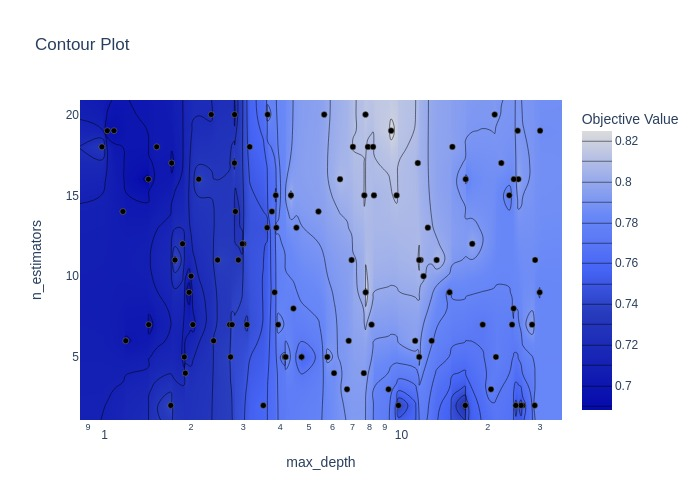

In [19]:
fig = optuna.visualization.plot_contour(study, params=['n_estimators', 'max_depth'])

# To display fig in an orinary norebook use `fig.show()`
# The following is needed only to display the image in an online Jupyter Book
# Or is you wish to save the figure

filename = './images/temp.jpg'
fig.write_image(filename)
display(Image(filename))